In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import torch.utils.data
from torch.utils.data import DataLoader
from collections import Counter

from utils import EmotionsDataset, SimpleNet, AttentionalNet

In [2]:
# define dictionary for emotions
emotion_dict = {0: 'Angry', 
                1: 'Disgust', 
                2: 'Fear',
                3: 'Happy', 
                4: 'Sad',
                5: 'Surprise',
                6: 'Neutral'}

In [3]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
dataset_train = EmotionsDataset(root='../dataset', fname='icml_face_data_train.csv', transform=transform)
dataset_validation = EmotionsDataset(root='../dataset', fname='icml_face_data_validation.csv', transform=transform)
dataset_test = EmotionsDataset(root='../dataset', fname='icml_face_data_test.csv', transform=transform)

Loading dataset...	Done
Loading dataset...	Done
Loading dataset...	Done


In [6]:
torch.manual_seed(0)
trainloader = DataLoader(dataset_train, batch_size = batch_size,shuffle=True)
valloader = DataLoader(dataset_validation, batch_size = batch_size,shuffle=True)
testloader = DataLoader(dataset_test, batch_size = batch_size)

In [7]:
class Face_Emotion_CNN(nn.Module):
    def __init__(self):
        super(Face_Emotion_CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5,padding=3)
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4,padding=2)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,padding=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128,kernel_size=5,padding=3)
        self.cnn5 = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=4,padding=2)

        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(3,stride=2)
        self.cnn1_bn = nn.BatchNorm2d(32)
        self.cnn2_bn = nn.BatchNorm2d(32)
        self.cnn3_bn = nn.BatchNorm2d(64)
        self.cnn4_bn = nn.BatchNorm2d(128)
        self.cnn5_bn = nn.BatchNorm2d(128)
       

        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2 = nn.Linear(1024, 7)
        self.dropout = nn.Dropout(0.3)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.pool(self.cnn1_bn(self.cnn1(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn2_bn(self.cnn2(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn3_bn(self.cnn3(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn4_bn(self.cnn4(x))))
        #print(x.shape)
        x = self.relu((self.cnn5_bn(self.cnn5(x))))
        #print(x.shape)

        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0],128*4*4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(self.dropout(x)))
        x = self.log_softmax(x)
        return x
    
torch.manual_seed(0)
model = Face_Emotion_CNN()

In [8]:
#PATH = './Kim_model_new_layer_20epoch.pth'
#PATH='./Kim_model_new_layer_20epoch_without_weightdecayandlrdecay.pth'
#PATH = './Kim_samemodel_0.01_withoutdecayandlr.pth'
PATH = '../experiments/7Layer_val_nowd-nopreprocess_Balanced.pth'
#torch.save(model.state_dict(), PATH)

In [9]:
#model = Face_Emotion_CNN()
model.load_state_dict(torch.load(PATH))
model.eval()

Face_Emotion_CNN(
  (cnn1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (cnn2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (cnn3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (cnn4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (cnn5): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=204

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #break

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 61.46558930064085 %


In [11]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Angry is 54.4 %
Accuracy for class: Disgust is 38.2 %
Accuracy for class: Fear  is 41.5 %
Accuracy for class: Happy is 82.7 %
Accuracy for class: Sad   is 48.8 %
Accuracy for class: Surprise is 72.4 %
Accuracy for class: Neutral is 60.9 %


<AxesSubplot:>

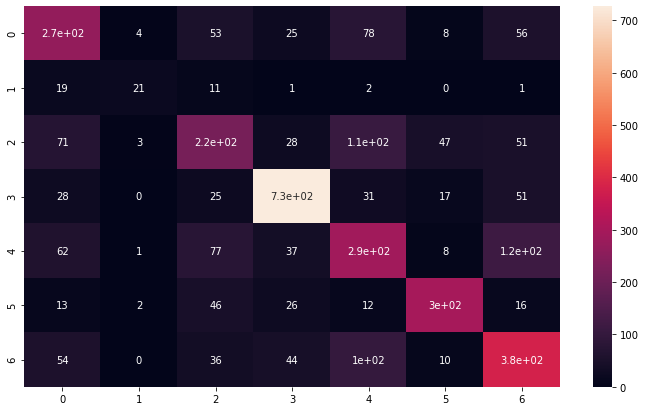

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model(inputs) # Feed Network

        output = (torch.max(output, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

In [13]:
cf_matrix

array([[267,   4,  53,  25,  78,   8,  56],
       [ 19,  21,  11,   1,   2,   0,   1],
       [ 71,   3, 219,  28, 109,  47,  51],
       [ 28,   0,  25, 727,  31,  17,  51],
       [ 62,   1,  77,  37, 290,   8, 119],
       [ 13,   2,  46,  26,  12, 301,  16],
       [ 54,   0,  36,  44, 101,  10, 381]], dtype=int64)